In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Puyuan Mi (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Model Error Quantification of Inverse Problem
### Puyuan Mi (pumi@dtu.dk)

Substituting a computationally expensive forward model with a cheap approximation is desirable in MCMC sampling from the perspective of reducing computional costs. Nevertheless, such an approach introduces a potential challenge—model errors that may compromise the accuracy of posterior inference. This notebook explores the use of error models to enhance the precision of posterior inference, particularly within the framework of a 2D deconvolution problem.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF
from cuqi.sampler import LinearRTO, pCN, CWMH, ULA, MALA, NUTS
from cuqi.problem import BayesianProblem
from cuqi.model import LinearModel
from cuqi.data import p_power

In [3]:
# Set seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.7.0



## 1. Deconvolution
Deconvolution concerns the following linear inverse problem
\begin{equation}
y_\text{data}=Ax_\text{exact}+e
\end{equation}
Where $A$ is some PSF operator, $x_\text{exact}$ is the exact image, $y_\text{data}$ is the blurred image, and $e$ is some white noise. Sometimes it's tricky to get the explicit $A$, while an approximated convolution operator $\tilde{A}$ would introduce the model discrepancy. The problem concerning the model error is like
\begin{equation}
y_\text{data}=\tilde{A}x_\text{exact}+m+e,\ \quad 	ext{such that} \quad \ m = (A-\tilde{A})x_\text{exact}
\end{equation}
$m$ could be crutial but hard to formulate under Bayes' formula, and the enhanced error model would alleviate challenges.

In this test problem, we take $x_\text{exact}$ as the p-power class phantom from the cuqi.data. It is an image generated from a random pattern of nonzero pixels with correlation between pixels. We take $F$ as a Gaussian blur from cuqi.testproblem.

Image2D(4096,)


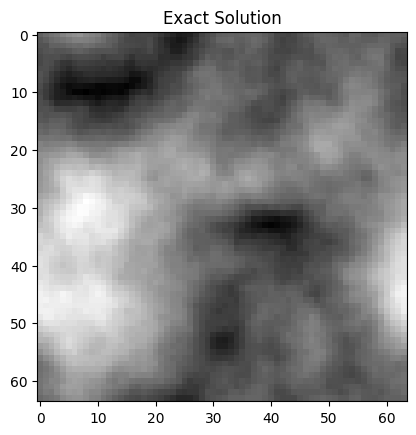

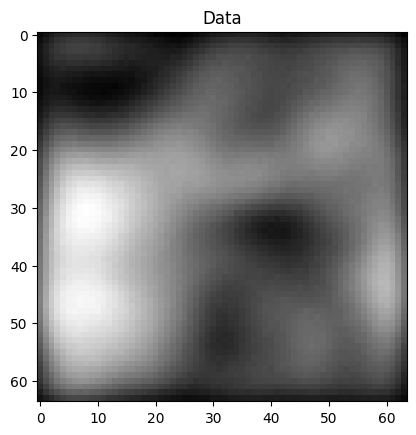

ProblemInfo with the following set attributes:
['exactData', 'infoString', 'exactSolution', 'Miscellaneous']
 infoString: Noise type: Additive Gaussian with std: 0.0036
 Miscellaneous: dict_keys(['PSF', 'BC'])


In [5]:
# Load forward model, data and problem information
phantom = p_power(relnz=1)
F, y_data, probInfo = Deconvolution2D(phantom=phantom,\
                                      dim=64,BC='zero').get_components()

# For convenience, we define the dimension of the domain of A
n = F.domain_dim
m = F.range_dim

M_exact = None
if 0:
    # PSF matrix
    M_exact = F.get_matrix()

# For convenience, we extract the exact solution as x_exact
x_exact = probInfo.exactSolution
print(x_exact.geometry)

# Plot the data
plt.figure()
x_exact.plot(); plt.title('Exact Solution'); 
plt.figure()
y_data.plot(); plt.title('Data')
plt.show()

# Print information about the problem
print(probInfo)

We take $f$ as an out-of-focus blur from cuqi.testproblem.

In [6]:
# Load approximated forward model
f = Deconvolution2D(PSF = "Defocus", dim=64, BC = 'zero').get_components()[0]

if M_exact is not None:
    # model discrepency
    M_f = f.get_matrix()
    M_d = M_exact-M_f
    fig = plt.imshow(M_d.toarray())
    plt.colorbar(fig)
    plt.show()


We define the prior $x \sim \text{GMRF}(x_0, \Gamma_x)$, which could be a good illustration of the p-power class phantom as the correlation only exists significantly in the neighbourhood of any pixel.

Image2D(4096,)


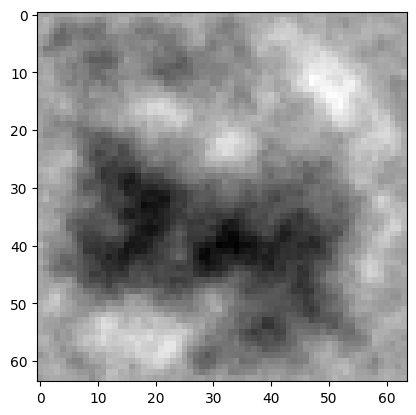

In [7]:
# prior mean
x_mean = 0.5*np.ones(n)

# prior precision
x_perc = 100

# prior
x = GMRF(mean=x_mean, prec = x_perc, physical_dim=2, bc_type = "zero", order=2)
# Sampling not implemented for zero boundary conditions in 2D
print(x.geometry)

# prior instance
x.sample(1).plot()

We take the noise $e \sim \text{Gaussian}(e_0, \Gamma_e)$ for the white noise.

In [8]:
# noise mean
e_mean = np.zeros(m)

# noise cov
e_cov = 0.0001

## 2. Enhanced error model

The enhanced error model (EEM, or AEM as the approximated error model) concerns the model error in the formulation of the likelihood. It assumes that $m$ is independent from $x$ with Gaussian distribution of mean $m_0$ and covariance $\Gamma_m$. Moreover, Given prior samples $X_i^0 \sim \pi(x), i=1,...,N$, $m_0^1$ and $\Gamma_m^1$ are approximated upon samples of the model error $M_i^1 = (A-\tilde{A})X_i^0$ as
\begin{equation}
m_0^1 \approx \text{mean}(M_i),\ \Gamma_m^1 \approx \text{cov}(M_i).
\end{equation}
Introducing $v^1 = m^1 + e$, then $v^1$ is also independent from $x$ with Gaussian distribution with mean $v_0^1 = m_0^1$
and covariance $\Gamma_v^1 = \Gamma_m^1 + \Gamma_e$. The corresponding likelihood is like
\begin{equation}
L_\text{EEM}^1(x|y=y_\text{data}) = \text{Gaussian}(\tilde{A}x+v_0^1, \Gamma_v^1)
\end{equation}

In [9]:
# sample the model error

def AEM_forward_sampler(F, f, xs, sampleN):
    # Get samples of the model error    
    ms = (F@xs).samples - (f@xs).samples
    m_mean = np.mean(ms, axis=1)
    m_cov = np.cov(ms)

    return m_mean, m_cov

sampleN = 1000
# prior sampling
xs = x.sample(sampleN)
m_mean, m_cov = AEM_forward_sampler(F, f, xs, sampleN)

# likelihood
y = Gaussian(f@x, e_cov+m_cov)

Now we could define the posterior under Bayes' formula as
\begin{equation}
P_\text{EEM}^1(x|y=y_\text{data}) \propto L_\text{EEM}^1(x|y=y_\text{data})Pr(x)
\end{equation}

In [10]:
# Define posterior
post_EEM = BayesianProblem(y, x).set_data(y=y_data-m_mean)
print(post_EEM)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI GMRF.
 )


We sample the posterior with linear RTO.

In [11]:
# Linear RTO sampling
samples_EEM = post_EEM.sample_posterior(sampleN)

# sample mean
mean_EEM = samples_EEM.mean()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 288.05121064186096


We show UQ results.

 None,

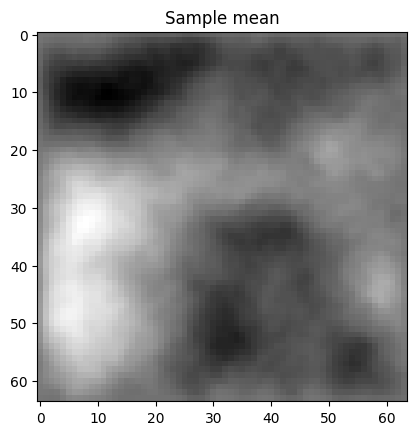

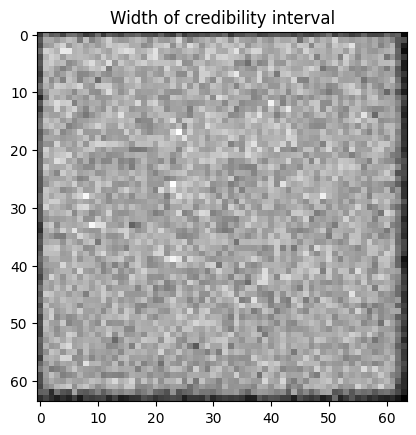

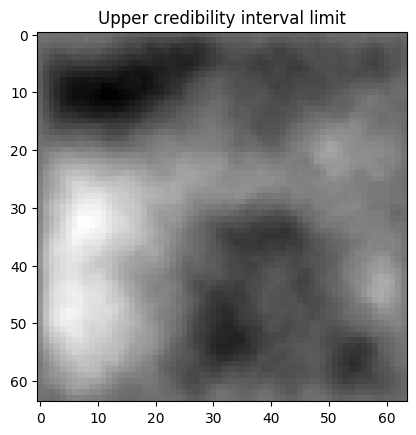

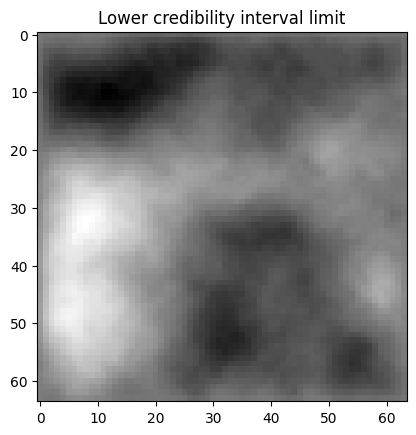

In [12]:
# UQ result
samples_EEM.plot_ci()

To do comparison, we also need to formulate the reference posterior $P_{A}$ and the posterior concerning no model error $P_{\tilde{A}}$. Posteriors are
\begin{equation}
P_{A}(x|y=y_\text{data}) \propto L_{A}(x|y=y_\text{data})Pr(x),\ s.t.\ L_{A}(x|y=y_\text{data}) = \text{Gaussian}(Ax, \Gamma_e)
\end{equation}
and
\begin{equation}
P_{\tilde{A}}(x|y=y_\text{data}) \propto L_{\tilde{A}}(x|y=y_\text{data})Pr(x),\ s.t.\ L_{\tilde{A}}(x|y=y_\text{data}) = \text{Gaussian}(\tilde{A}x, \Gamma_e)
\end{equation}
respectively.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 34.36532759666443


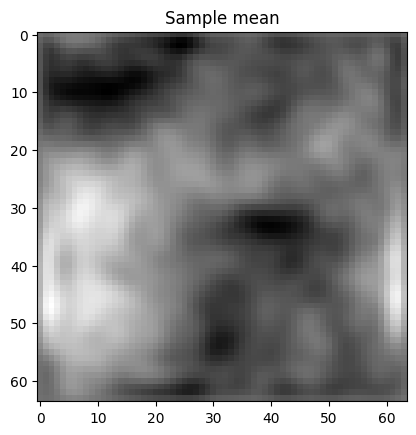

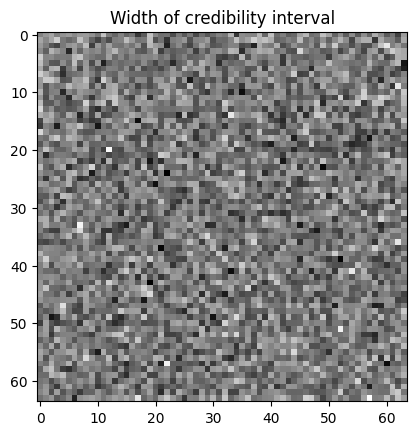

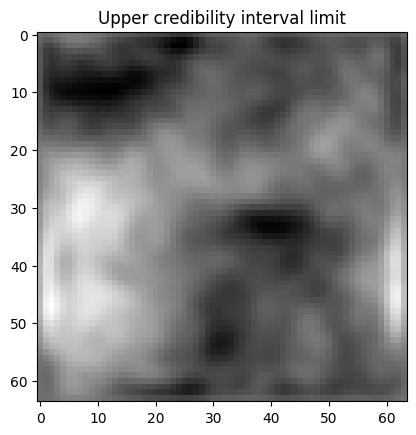

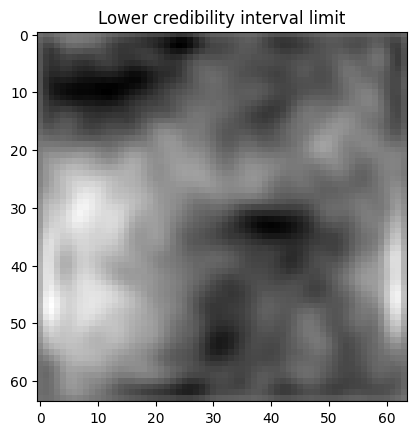

In [13]:
# Reference

# likelihood
y_F = Gaussian(F@x, 0.0036**2)

# posterior
post_F = BayesianProblem(y_F, x).set_data(y_F=y_data)

# sampling
samples_F = post_F.sample_posterior(sampleN)

# UQ result
samples_F.plot_ci()

# sample mean
mean_F = samples_F.mean()

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 35.723061084747314


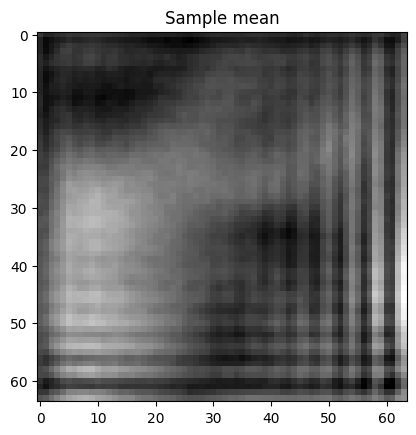

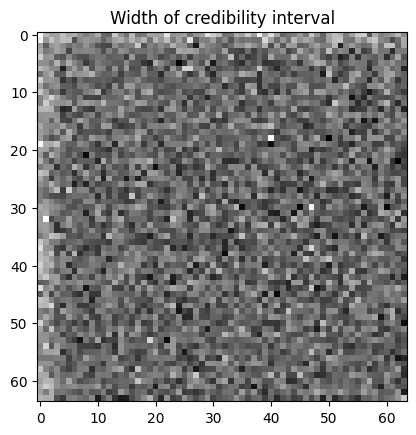

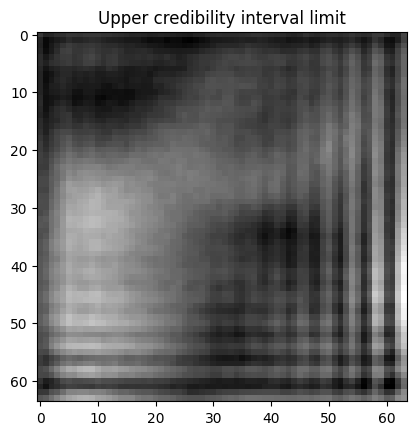

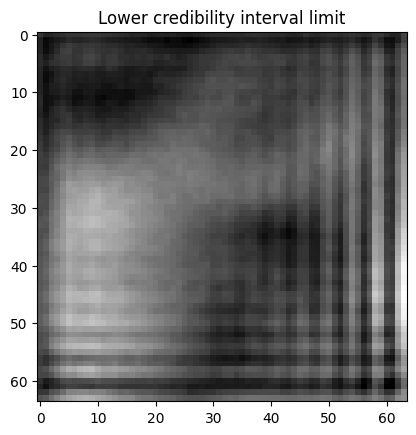

In [14]:
# likelihood
y_f = Gaussian(f@x, 0.0036**2)

# posterior
post_f = BayesianProblem(y_f, x).set_data(y_f=y_data)

# sampling
samples_f = post_f.sample_posterior(sampleN)

# UQ result
samples_f.plot_ci()

# sample mean
mean_f = samples_f.mean()


We compare the relative error of the posterior mean of $P_\text{EEM}$ and $P_{\tilde{A}}$ with $P_A$.

In [15]:
# comparison on sample mean
print(f"re without model error = {np.linalg.norm(mean_f-mean_F)/np.linalg.norm(mean_F)}")
print(f"re with model error = {np.linalg.norm(mean_EEM-mean_F)/np.linalg.norm(mean_F)}")

re without model error = 0.23926863329692255
re with model error = 0.1479598745499751


## 3. Iterative updated error model

The iterative updated error model (IUEM) iteratively updates the model error and the corresponding posterior in order to get a better posterior estimate. More percisely, after getting $P_\text{EEM}$, IUEM draws samples $X_i^1 \sim P_\text{EEM}$ and updates model error samples as $M_i^2 = (A-\tilde{A})X_i^1$. The posterior is correspondingly updated and the process is iterated as
\begin{equation}
M_i^{k+1} = (A-\tilde{A})X_i^k, \ P_\text{EEM}^{k+1}(x|y=y_\text{data}) \propto L_\text{EEM}^{k+1}(x|y=y_\text{data})Pr(x)
\end{equation}
where
\begin{equation}
L_\text{EEM}^{k+1}(x|y=y_\text{data}) = \text{Gaussian}(\tilde{A}x+v_0^{k+1}, \Gamma_v^{k+1})
\end{equation}
with $v_0^{k+1} = \text{mean}(M_i^{k+1})$ and $\Gamma_v^{k+1} = \text{cov}(M_i^{k+1})+\Gamma_e$
until the posterior gets stable.

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 262.04546093940735


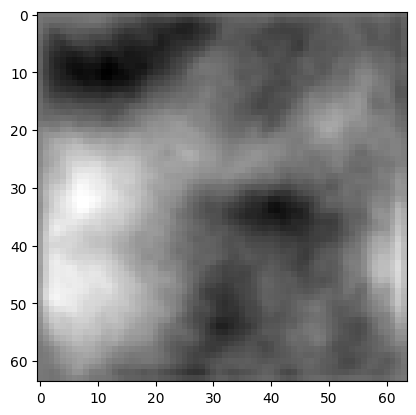

re of 2th iteration IUEM = 0.07793370641364311
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 258.57583117485046


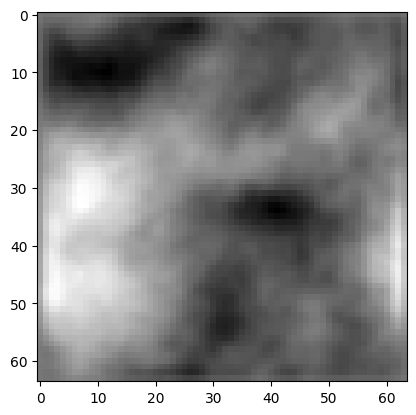

re of 3th iteration IUEM = 0.06065299811799275
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 272.8026566505432


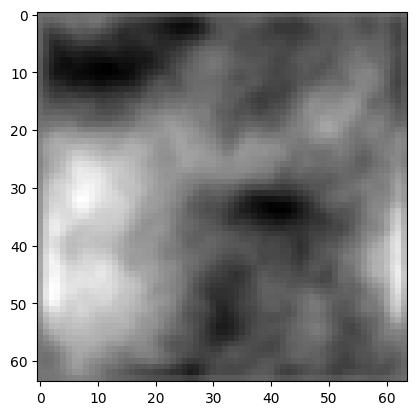

re of 4th iteration IUEM = 0.05204941027904733
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 289.7094657421112


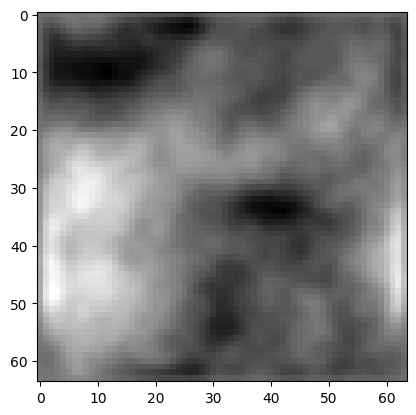

re of 5th iteration IUEM = 0.04617004034066002
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 294.94091963768005


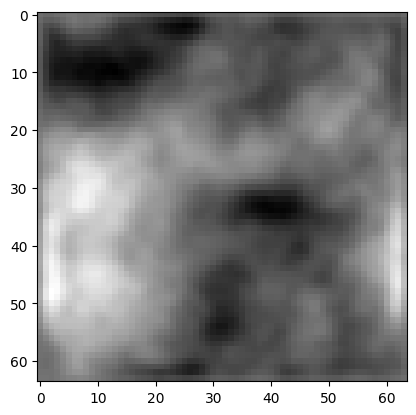

re of 6th iteration IUEM = 0.044330344848659435
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 288.35623025894165


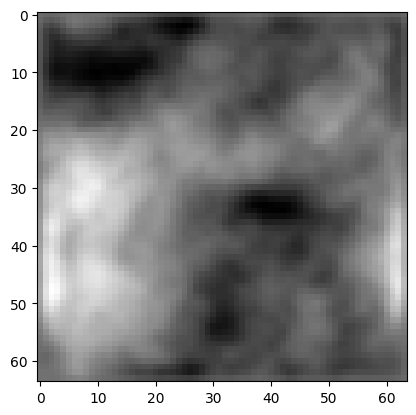

re of 7th iteration IUEM = 0.04194778144236438
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 304.9461452960968


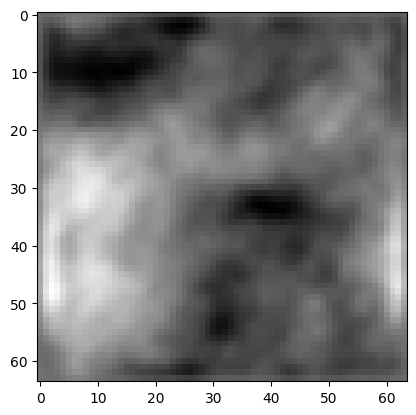

re of 8th iteration IUEM = 0.03967731019916941
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 292.4063172340393


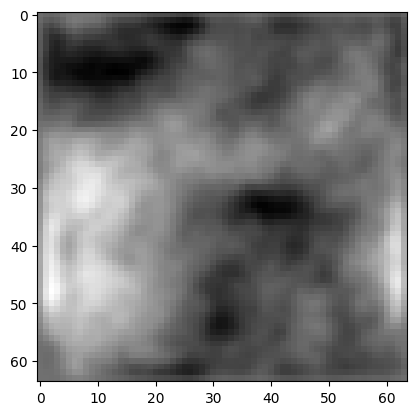

re of 9th iteration IUEM = 0.03848413800098121
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 360.3718101978302


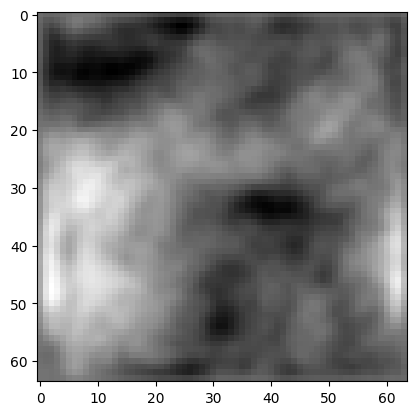

re of 10th iteration IUEM = 0.038093400576467686


In [16]:
# total iterations
iterations = 10
res = []
for k in range(1, iterations):
    # model error
    m_mean, m_cov = AEM_forward_sampler(F, f, samples_EEM, sampleN)
    # likelihood
    y = Gaussian(f@x, e_cov+m_cov)
    # posterior
    post_EEM = BayesianProblem(y, x).set_data(y=y_data-m_mean)
    # sampling
    samples_EEM = post_EEM.sample_posterior(sampleN)
    # sample mean
    mean_EEM = samples_EEM.mean()
    # UQ result
    cuqi.array.CUQIarray(mean_EEM, geometry=F.domain_geometry).plot()
    plt.show()
    # comparison on sample mean
    re = np.linalg.norm(mean_EEM-mean_F)/np.linalg.norm(mean_F)
    res.append(re)
    print(f"re of {k+1}th iteration IUEM = {re}")
    

We plot the relative error of the posterior mean comparing to that of $P_A$ w.r.t iterations.

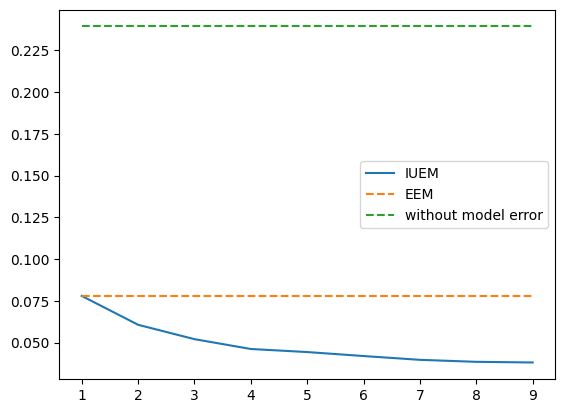

In [17]:
plt.figure()
xlim = np.arange(1,10)
plt.plot(xlim, res, label='IUEM')
plt.plot(xlim, res[0]*np.ones(iterations-1), '--', label='EEM')
plt.plot(xlim, np.linalg.norm(mean_f-mean_F)/np.linalg.norm(mean_F)*np.ones(iterations-1), \
         '--', label='without model error')
plt.legend()
plt.show()